# **Classification of the "Intel Image Classification" Dataset**

We Start by importing the needed libraries

In [153]:
from pathlib import Path
import matplotlib.pyplot as plt

from random import randint as rand
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.io import read_image

In [154]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [155]:
transform = v2.Compose([
    v2.ToImage(),
    v2.Normalize((0.5,), (0.5,))
])

In [156]:
data = []
path = Path("./Data/seg_train/seg_train")

img = []
targets = []
for folder in path.iterdir():
    for file in folder.iterdir():
        img.append(read_image(str(file)))
        targets.append(folder.name)

classes = np.unique(targets)
targets = [np.where(classes == target)[0][0] for target in targets]

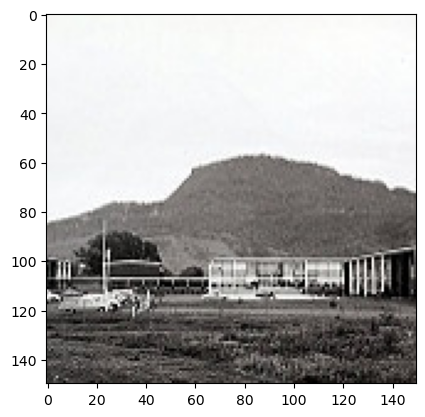

In [157]:
r = rand(0, len(img))
plt.imshow(v2.ToPILImage()(img[0]))
plt.show()

In [158]:
targets[0]

0

Data targets:

0. buildings
1. forest
2. glacier
3. mountain
4. sea
5. street

In [159]:
print(img[0].shape)
print(img[0].dtype)

torch.Size([3, 150, 150])
torch.uint8


In [160]:
for i in range(len(img)):
    img[i] = img[i].float().to(device)

In [161]:
img[rand(0, len(img))].dtype

torch.float32

In [162]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # Input size - Kernel size / Stride + 1 = Output size (6,146,146)
        self.pool = nn.MaxPool2d(2, 2) # Divide the size by 2 (6,73,73)
        self.conv2 = nn.Conv2d(6, 16, 5) # (16,69,69) -> (16,34,34) (Because of the pooling layer (again)) -> Flatten (16*34*34) = 18496
        
        #Dense layers
        
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [163]:
model = Model()

In [164]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)